In [1]:
import os
import pandas as pd
from bertopic import BERTopic
from nltk import FreqDist
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.datasets import fetch_20newsgroups
from stop_words import get_stop_words
import spacy
import warnings

os.chdir("../")
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth = 200

from src.modeling import BERTopic_
from src.config import (
    umap_data,
    hdbscan_data,
    sent_transformers_data,
    tfidf_data,
    tokenizer_data,
    mmr_data,
    bertopic_data,
)
from src.data_preprocess import Preprocessing
from src.utils import (
    getClusteringModel,
    getDimReductionModel,
    getMaximalMarginalRelevance,
    getTfidfTransformers,
    getTokenizer,
    getEmbeddings,
    getFrequencyDictForText,
    create_wordcloud,
    global_wordcloud,
    context_stopword
)

# Configs Params

In [2]:
with open(f'./data/context-sw.txt') as f:
    list_context_sw = [line.strip() for line in f.readlines()]
f.close()

language = "french"
spacy_model = 'fr_core_news_md'
transformer = "dangvantuan/sentence-camembert-large"
preprocessor = Preprocessing(spacy_model, language, list_context_sw)

docs_name = "chatbot-sample"

# Metadata Stats

In [3]:
sample_file_path =  "./data/chatbot_data_file.csv"
with open(sample_file_path, 'rb') as f:
    df_docs = pd.read_csv(f, sep="|", encoding="utf-8")

df_docs["language"] = df_docs["question"].apply(preprocessor.getLanguage).apply(lambda x: x if x in ["fr", "en"] else 'other_lang')

df_docs["length"] = df_docs["question"].apply(lambda x: len(x.split(" ")))

In [4]:
df_docs.head()

date   
0  2021-09-08  \
1  2021-09-09   
2  2021-09-09   
3  2021-09-09   
4  2021-09-09   

                                                                 question   
0                                 quel type de justificatif professionnel  \
1  les avantages club totalenergies peuvent servir comme assurance auto ?   
2                                          comment récupérer mes points ?   
3                                            je n arrive pas à m inscrire   
4                            je souhaite modifier mes numéros de la carte   

  language  length  
0       fr       5  
1       fr      10  
2       fr       5  
3       fr       7  
4       fr       8

In [5]:
df_lang = df_docs[["language", "question"]].groupby("language").count().reset_index()
df_lang

language  question
0          en       215
1          fr      9470
2  other_lang      1842

In [6]:
fig = px.pie(df_lang, values='question', names='language', title='Represented languages in docs', width=500)
fig.show()

In [7]:
fig = px.histogram(df_docs, x="length", width=800, height=500, labels={"length": "Question Length"}, histnorm='probability density')
fig.show()

# Custom Model Test

In [8]:
# keep docs in language = "french" only
df_docs = df_docs[df_docs["language"] != 'en'].reset_index(drop=True)
df_docs.head()

date   
0  2021-09-08  \
1  2021-09-09   
2  2021-09-09   
3  2021-09-09   
4  2021-09-09   

                                                                 question   
0                                 quel type de justificatif professionnel  \
1  les avantages club totalenergies peuvent servir comme assurance auto ?   
2                                          comment récupérer mes points ?   
3                                            je n arrive pas à m inscrire   
4                            je souhaite modifier mes numéros de la carte   

  language  length  
0       fr       5  
1       fr      10  
2       fr       5  
3       fr       7  
4       fr       8

In [9]:
docs = df_docs["question"].apply(preprocessor.pipeline).tolist()

In [10]:
df_docs["question"].apply(preprocessor.pipeline)

0                                                                                                         type justificatif professionnel
1                                                                                                          avantage servir assurance auto
2                                                                                                                         récupérer point
3                                                                                                                                inscrire
4                                                                                                                   modifier numéro carte
                                                                       ...                                                               
11307    humain lit nêtes vraiment malin bloquer compte mempêcher rouvrir adresse mail finalement réactiver prévenu top service clientèle
11308                             

In [11]:
getFrequencyDictForText(" ".join(docs), language, list_context_sw)

<MultiDict('oibl': 1, 'compatible': 1, 'claque': 1, 'jumeler': 1, 'varburer': 1, 'euroseri': 1, 'géant': 1, 'noisiel': 1, 'bézier': 1, 'demarrage': 1, 'loperation': 1, 'poidslourd': 1, 'accé': 1, 'decafer': 1, 'distance': 1, 'alorsalors': 1, 'chance': 1, 'permetell': 1, 'wd': 1, 'ptoblème': 1, 'stipe': 1, 'ribot': 1, 'brive': 1, 'gaillarde': 1, 'photocopie': 1, 'nbonjour': 1, 'ténor': 1, 'chorale': 1, 'sérieusement': 1, 'majoritairement': 1, 'olá': 1, 'boa': 1, 'tarder': 1, 'conta': 1, 'atrasou': 1, 'françer': 1, 'ainda': 1, 'sei': 1, 'pagar': 1, 'será': 1, 'ajudar': 1, 'cgxg': 1, 'charactere': 1, 'ressenti': 1, 'recopier': 1, 'conexion': 1, 'caniote': 1, 'maffich': 1, 'assurezvous': 1, 'errrur': 1, 'systématique': 1, 'corba': 1, 'pourer': 1, 'roissy': 1, 'brie': 1, 'rouer': 1, 'jhabite': 1, 'carburante': 1, 'sylver': 1, 'fontonner': 1, 'délectriciter': 1, 'pasde': 1, 'rebasculer': 1, 'hu': 1, 'recue': 1, 'questinnaire': 1, 'efficace': 1, 'robotisee': 1, 'plante': 1, 'accepted': 1, 'ad

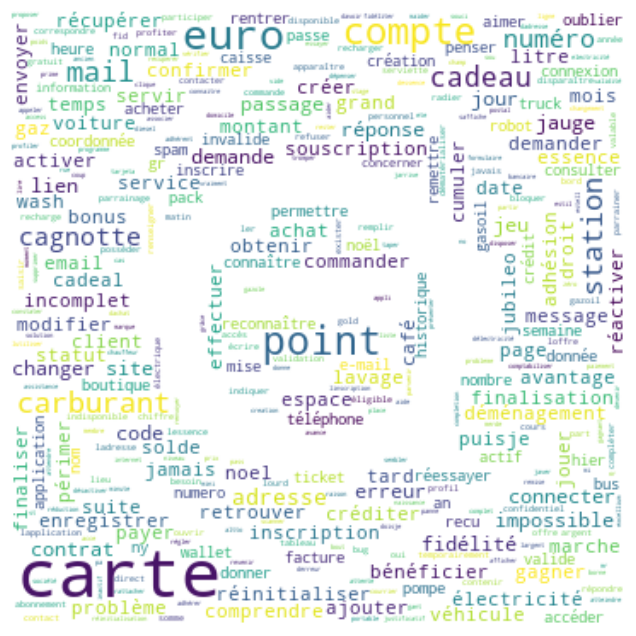

In [12]:
global_wordcloud(" ".join(docs), language, list_context_sw)

In [13]:
umap_model = getDimReductionModel(umap_data())
hdbscan_model = getClusteringModel(hdbscan_data())
vectorizer_model = getTokenizer(tokenizer_data(language=language), list_context_sw)
ctfidf_model = getTfidfTransformers(tfidf_data())
mmr_model = getMaximalMarginalRelevance(mmr_data())

In [14]:
bertopic_config = bertopic_data(
    umap_model,
    hdbscan_model,
    vectorizer_model,
    ctfidf_model,
    mmr_model,
    nr_topics=100
)

bert_topic_inst = BERTopic_(bertopic_config)

In [15]:
bert_topic_inst.fit_or_load(transformer, docs_name, docs)

No sentence-transformers model found with name /home/onyxia/.cache/torch/sentence_transformers/dangvantuan_sentence-camembert-large. Creating a new one with MEAN pooling.


In [16]:
bert_topic_inst.barchart_()

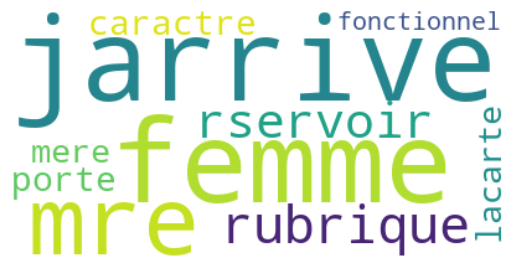

In [17]:
create_wordcloud(bert_topic_inst.model, 0)

In [23]:
df_doc_topic = bert_topic_inst.tabular_inference(docs)[1][["Document", "Topic", "Name", "Probability", "Representative_document"]]

In [26]:
df_doc_topic[df_doc_topic["Representative_document"]].sort_values("Topic").reset_index(drop=True)

Document   
0                                                                   recu mail confirmation validation email e-mail envoyer ouvrir réception adhésion attention confirmation part heure demande invalidéepour  \
1    monsieur Monsieur permettre revenir réponse suite message suite disfonctionnement carte javais envoyer ticket paiement stipuler passageje doléance compte bénéficier avantage client remercier atten...   
2        mari dessence petrol station access situer rn rue albert thomas reims cb problème sest produire dessence ticket caisse lager assurer mari quaucune somme régler problème niveau réseau distribution   
3                                                                                                                                                                              famille vacance exemple carte   
4                                                                                                                                                                             jarrive consulter oublier mode   
..                                                                                                                                                                                                       ...   
561                                                                                                                                                                                                      jeu   
562                                                                                                                                                                                                      jeu   
563                                                                                                                                                                                                      mdp   
564                                                                                                                                                                                                       sm   
565                                                                                                                                                                                                       sm   

     Topic                            Name  Probability   
0       -1  -1_dessence_javer_dpenser_card     0.000000  \
1       -1  -1_dessence_javer_dpenser_card     0.000000   
2       -1  -1_dessence_javer_dpenser_card     0.000000   
3        0    0_jarrive_femme_mre_rubrique     0.753232   
4        0    0_jarrive_femme_mre_rubrique     1.000000   
..     ...                             ...          ...   
561     97              97_mans_jeu_heure_     1.000000   
562     97              97_mans_jeu_heure_     1.000000   
563     98                     98_sm_mdp__     1.000000   
564     98                     98_sm_mdp__     1.000000   
565     98                     98_sm_mdp__     1.000000   

     Representative_document  
0                       True  
1                       True  
2                       True  
3                       True  
4                       True  
..                       ...  
561                     True  
562                     True  
563                     True  
564                     True  
565                     True  

[566 rows x 5 columns]